# 🐠 Underwater Object Detection - UATD Dataset

**Problem Statement:**  
Develop a robust object detection algorithm to identify and localize underwater objects in multibeam forward-looking sonar (MFLS) images. The dataset contains over 9,000 images annotated with bounding boxes for 10 distinct object categories.

**What we Need to Do:**  
From an input sonar image, your pipeline should output:  
- **Bounding Boxes:** Accurate coordinates around each detected object.  
- **Class Labels:** Correct category identification for each bounding box.

# Target Images

![target_images](./target_images.png)

# Provided Image example(UATD)

![Given Image Example](./07600.jpg)

# Image with bounding box and corresponding label

![Target Example](./target_example.png)

# Image Intensity Graph

![ImageIntensentyGraph](./3d_intensity.png)



## 🧭 Full Project Journey 


### 🔍 Step 1: Understanding the Problem

- Read the problem statement thoroughly ➡️
- Explored the dataset (images, annotations, intensity maps) ➡️
- Understood how sonar images are represented and labeled

🎯 Goal: Build a full detection system (not just classification)

---

### 🧰 Step 2: Dataset Structuring

- Mapped each image with its annotations ➡️
- Created a combined `.csv` to align images, classes, and bounding boxes

---

### 🧠 Step 3: Tried Traditional Machine Learning

- Applied classical ML models for classification ➡️
- Achieved **~72% accuracy**, but…

🚫 **Limitation:** Only classification, no object localization

---

### 🤖 Step 4: Shift to Deep Learning

- Tried **ResNet18** for image classification ➡️
- Slight accuracy improvement, but still no bounding boxes

---

### ⚠️ Step 5: Challenges Faced

- Dataset was **large** and **computationally heavy**
- Initial training was **very slow**, with **no proper preprocessing**
- Tried **Faster R-CNN**, but:
  - Results were below expectations
  - Training time was high
  - Resource limitations made model training inefficient

---

### 💡 Step 6: Realization & Pivot

➡️ Understood the importance of **data preprocessing**

🔧 Applied the following changes:
- Converted `.bmp` to `.jpg` for efficiency
- Reduced image resolution
- Transformed grayscale to 3-channel (RGB) format

📈 Result: Significantly faster training and more stable performance

---

### 📚 Step 7: Discovered YOLO

- Came across **YOLO (You Only Look Once)** – optimized for fast object detection  
- Found specific use cases where YOLO worked well for underwater imagery  
- Studied YOLO architecture and transfer learning capabilities

---

### 🔁 Step 8: Final Training with YOLO

- Applied **transfer learning** on preprocessed images using YOLO  
- Tuned training pipeline and hyperparameters  
- Evaluated with standard object detection metrics

---

## ✅ Results (Final Evaluation)

| **Metric**          | **Outcome**                |
|---------------------|-----------------------------|
| 📈 **mAP@0.5**       | ✅       |
| 🎯 **mAP@0.5:0.95**  | ✅    |
| 🔍 **Precision**     | ✅ |
| 🔁 **Recall**        | ✅  |

---

## 🚀 Summary

We started by understanding the data and applying basic models, then evolved to deep learning. After facing inefficiencies, we redesigned the preprocessing pipeline and implemented YOLO with transfer learning, which led to a high-performing underwater object detection system.

---

## 🔮 Future Scope

- Using OA-ELAN, SPPCSPCBiFormer & G-ELAN-H in YOLO
- Optimize anchor boxes for sonar-specific shapes
- Improve image preprocessing
- Try **semi-supervised learning** for unlabeled data
- Deploy in real-time underwater robotic systems
- Make an end to end Project



# Complete Script 

### YOLOv8

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Understanding images and annotations

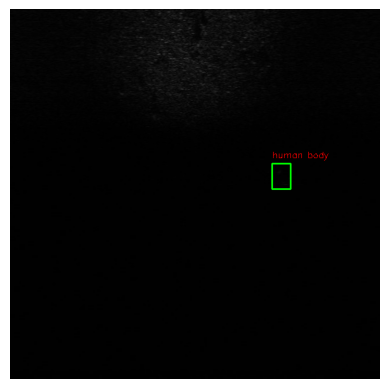

In [19]:
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Load image
img = cv2.imread("/kaggle/input/uatd-processed/processed_uatd/processed_training/images/00001.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load and parse XML
tree = ET.parse("/kaggle/input/uatd-processed/processed_uatd/processed_training/annotations/00001.xml")
root = tree.getroot()

# Draw bounding boxes
for obj in root.findall("object"):
    name = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin, ymin, xmax, ymax = [int(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
    cv2.putText(img, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.imshow(img)
plt.axis("off")
plt.show()


# Main Script

### Pipeline for Model training using YOLOv8n

```bash
  ┌──────────────────────────────┐
  │ 1. Dataset Preparation       │
  │ (Convert XML → YOLO labels)  │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 2. Folder Structure Setup    │
  │ (train/valid, images/labels) │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 3. Create dataset.yaml       │
  │ (class mapping, image paths) │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 4. Load YOLOv8n Model        │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 5. Train the Model           │
  │ (epochs, batch, imgsz)       │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 6. Validate the Model        │
  └────────────┬─────────────────┘
               ↓
  ┌──────────────────────────────┐
  │ 7. Run Predictions / Plot    │
  │                              │
  └──────────────────────────────┘

```

In [20]:
from ultralytics import YOLO
import os
import yaml
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch

# Define paths to your data
train_images_dir = "/kaggle/input/uatd-processed/processed_uatd/processed_training/images"
train_annotations_dir = "/kaggle/input/uatd-processed/processed_uatd/processed_training/annotations"
test_images_dir = "/kaggle/input/uatd-processed/processed_uatd/processed_test_1/images"
test_annotations_dir = "/kaggle/input/uatd-processed/processed_uatd/processed_test_1/annotations"

# First, convert XML annotations to YOLO format
def convert_xmls_to_yolo(xml_dir, output_dir, img_width=640, img_height=640):
    """Convert XML annotations to YOLO txt format"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Update with your actual classes
    classes = [
        'Cube', 
        'Cylinder', 
        'Tyres', 
        'Ball', 
        'human body', 
        'circle cage', 
        'square cage', 
        'metal bucket', 
        'plane model', 
        'ROV'
    ]
    
    # Track class occurrences for statistics
    class_count = {cls: 0 for cls in classes}
    unknown_classes = {}
    processed_files = 0
    
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith('.xml'):
            continue
        
        processed_files += 1
        
        # Parse XML
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()
        
        # Create YOLO txt file (same basename but .txt extension)
        txt_filename = os.path.splitext(xml_file)[0] + '.txt'
        txt_path = os.path.join(output_dir, txt_filename)
        
        with open(txt_path, 'w') as f:
            # Get image size from XML
            size_elem = root.find('size')
            if size_elem is not None:
                width = int(size_elem.find('width').text)
                height = int(size_elem.find('height').text)
            else:
                # Use default if not found
                width, height = img_width, img_height
            
            # Process each object
            for obj in root.findall('object'):
                # Get class
                class_name = obj.find('name').text
                
                raw_class_name = obj.find('name').text.strip().lower()

                # Normalize
                if raw_class_name in ['tyre', 'tire']:
                    class_name = 'Tyres'
                elif raw_class_name in ['human', 'body']:
                    class_name = 'human body'
                elif raw_class_name in ['rov', 'robot']:
                    class_name = 'ROV'
                elif raw_class_name == 'ball':
                    class_name = 'Ball'
                elif raw_class_name == 'bucket':
                    class_name = 'metal bucket'
                elif raw_class_name == 'plane':
                    class_name = 'plane model'
                elif raw_class_name == 'cube':
                    class_name = 'Cube'
                elif raw_class_name == 'cylinder':
                    class_name = 'Cylinder'
                elif raw_class_name == 'circle cage':
                    class_name = 'circle cage'
                elif raw_class_name == 'square cage':
                    class_name = 'square cage'
                else:
                    class_name = raw_class_name  # fallback for unknown

               

                
                if class_name not in classes:
                    if class_name not in unknown_classes:
                        unknown_classes[class_name] = 0
                    unknown_classes[class_name] += 1
                    continue
                
                class_count[class_name] += 1
                class_id = classes.index(class_name)
                
                # Get bounding box
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                
                # Convert to YOLO format (normalized center x, center y, width, height)
                x_center = ((xmin + xmax) / 2) / width
                y_center = ((ymin + ymax) / 2) / height
                box_width = (xmax - xmin) / width
                box_height = (ymax - ymin) / height
                
                # Ensure values are within bounds [0,1]
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                box_width = max(0, min(1, box_width))
                box_height = max(0, min(1, box_height))
                
                # Write to file
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")
    
    # Print statistics
    print(f"Processed {processed_files} annotation files")
    print("Class distribution:")
    for cls, count in class_count.items():
        print(f"  {cls}: {count}")
    
    if unknown_classes:
        print("Unknown classes found:")
        for cls, count in unknown_classes.items():
            print(f"  {cls}: {count}")

# Create labels directories
os.makedirs("/kaggle/working/train/labels", exist_ok=True)
os.makedirs("/kaggle/working/valid/labels", exist_ok=True)

# Make symlinks for images (to avoid copying large files)
os.makedirs("/kaggle/working/train/images", exist_ok=True)
os.makedirs("/kaggle/working/valid/images", exist_ok=True)

# Convert annotations to YOLO format
print("Converting training annotations...")
convert_xmls_to_yolo(train_annotations_dir, "/kaggle/working/train/labels")
print("\nConverting validation annotations...")
convert_xmls_to_yolo(test_annotations_dir, "/kaggle/working/valid/labels")

# Create symbolic links for images
print("Creating image symbolic links...")

# For training images
for img_file in os.listdir(train_images_dir):
    if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        src = os.path.join(train_images_dir, img_file)
        dst = os.path.join("/kaggle/working/train/images", img_file)
        if not os.path.exists(dst):
            os.symlink(src, dst)

# For validation images
for img_file in os.listdir(test_images_dir):
    if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        src = os.path.join(test_images_dir, img_file)
        dst = os.path.join("/kaggle/working/valid/images", img_file)
        if not os.path.exists(dst):
            os.symlink(src, dst)

# Create dataset YAML file - USING THE CORRECT FORMAT YOLOv8 EXPECTS
dataset_yaml = {
    'path': '/kaggle/working',  # Root directory
    'train': '/kaggle/working/train/images',  # Train images
    'val': '/kaggle/working/valid/images',    # Val images
    'nc': 10,  # Number of classes
    'names': {  # Class names
        0: 'Cube',
        1: 'Cylinder',
        2: 'Tyres',
        3: 'Ball',
        4: 'human body',
        5: 'circle cage',
        6: 'square cage',
        7: 'metal bucket',
        8: 'plane model',
        9: 'ROV'
    }
}

# Write YAML file
with open('/kaggle/working/dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f)

print("Dataset YAML created")

# Initialize YOLO model
model = YOLO('yolov8n.pt')  # Use nano model to start with (smallest)

# Train the model
print("Starting model training...")
results = model.train(
    data='/kaggle/working/dataset.yaml',
    epochs=20,  # Start with fewer epochs
    imgsz=640,
    batch=32,    # Small batch size to avoid memory issues
    patience=10,
    save=True,
    device=0 if torch.cuda.is_available() else 'cpu'
)

# Validate the model
print("Validating model...")
val_results = model.val()

# Test on a few images
print("Testing on a sample image...")
test_img = cv2.imread("/kaggle/input/uatd-processed/processed_uatd/processed_test_1/images/00001.jpg")
results = model.predict(test_img, conf=0.25)

# Show results
res_plotted = results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Converting training annotations...
Processed 7600 annotation files
Class distribution:
  Cube: 2647
  Cylinder: 564
  Tyres: 1125
  Ball: 3072
  human body: 1285
  circle cage: 661
  square cage: 982
  metal bucket: 476
  plane model: 795
  ROV: 700

Converting validation annotations...
Processed 800 annotation files
Class distribution:
  Cube: 172
  Cylinder: 48
  Tyres: 122
  Ball: 197
  human body: 76
  circle cage: 99
  square cage: 167
  metal bucket: 6
  plane model: 135
  ROV: 150
Creating image symbolic links...
Dataset YAML created
Starting model training...
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/dataset.yaml, epochs=20, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=Fal

train: Scanning /kaggle/working/train/labels... 7600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7600/7600 [00:05<00:00, 1380.20it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 65.2±37.7 MB/s, size: 52.0 KB)


val: Scanning /kaggle/working/valid/labels... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:01<00:00, 758.15it/s]

val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.74G      1.969       3.53      1.237         34        640: 100%|██████████| 238/238 [01:14<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


                   all        800       1172      0.515      0.503      0.497      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.06G      1.755      1.804      1.193         31        640: 100%|██████████| 238/238 [01:12<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

                   all        800       1172      0.713      0.676       0.72      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.06G      1.699      1.339      1.183         34        640: 100%|██████████| 238/238 [01:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


                   all        800       1172      0.711      0.684      0.702      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.06G      1.682      1.156      1.182         33        640: 100%|██████████| 238/238 [01:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

                   all        800       1172      0.643      0.605      0.606      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.06G       1.65      1.034       1.17         35        640: 100%|██████████| 238/238 [01:11<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

                   all        800       1172      0.806      0.704      0.727        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.06G      1.614     0.9573      1.152         42        640: 100%|██████████| 238/238 [01:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

                   all        800       1172      0.845      0.749      0.781      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.06G       1.59     0.9103      1.139         47        640: 100%|██████████| 238/238 [01:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

                   all        800       1172      0.844      0.776      0.799      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.06G      1.574     0.8687      1.128         33        640: 100%|██████████| 238/238 [01:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

                   all        800       1172      0.727      0.728      0.723      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.06G      1.563     0.8349       1.13         31        640: 100%|██████████| 238/238 [01:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

                   all        800       1172      0.839      0.772      0.769      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.06G      1.543     0.8011      1.123         35        640: 100%|██████████| 238/238 [01:12<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

                   all        800       1172      0.841      0.761      0.796      0.358


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.06G      1.525     0.7463      1.179         27        640: 100%|██████████| 238/238 [01:12<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


                   all        800       1172      0.852      0.809      0.819      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.06G      1.504      0.709      1.167         25        640: 100%|██████████| 238/238 [01:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


                   all        800       1172      0.786      0.608      0.668      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.06G      1.485      0.692      1.154         22        640: 100%|██████████| 238/238 [01:10<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

                   all        800       1172      0.843      0.809      0.807      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.06G      1.477     0.6749      1.155         28        640: 100%|██████████| 238/238 [01:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

                   all        800       1172      0.832      0.808      0.798      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.06G       1.45     0.6489      1.144         23        640: 100%|██████████| 238/238 [01:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


                   all        800       1172      0.859      0.802      0.816      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.06G      1.434      0.637      1.135         26        640: 100%|██████████| 238/238 [01:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


                   all        800       1172      0.823      0.764       0.75      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.06G      1.419      0.622      1.133         27        640: 100%|██████████| 238/238 [01:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

                   all        800       1172      0.831      0.739      0.744      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.06G      1.405       0.61      1.122         26        640: 100%|██████████| 238/238 [01:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]

                   all        800       1172      0.846      0.804      0.791      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.06G      1.389     0.5955      1.111         23        640: 100%|██████████| 238/238 [01:10<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


                   all        800       1172      0.831      0.809      0.787      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.06G       1.37     0.5868      1.104         26        640: 100%|██████████| 238/238 [01:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]

                   all        800       1172      0.839      0.813      0.791      0.355



20 epochs completed in 0.424 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


                   all        800       1172      0.852      0.808      0.819       0.37
                  Cube        172        172      0.686       0.93      0.688      0.241
              Cylinder         48         48      0.936      0.915       0.95      0.428
                 Tyres        122        122      0.912       0.85      0.906      0.408
                  Ball        197        197      0.803      0.883      0.841      0.459
            human body         76         76      0.847      0.877      0.805      0.339
           circle cage         99         99      0.736      0.424      0.572      0.263
           square cage        167        167      0.876      0.617      0.674      0.251
          metal bucket          6          6      0.795      0.833      0.836      0.286
           plane model        135        135      0.948      0.943      0.956      0.522
                   ROV        150        150      0.984      0.807      0.962      0.497


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train3
Validating model...
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 93.7±23.5 MB/s, size: 43.8 KB)


val: Scanning /kaggle/working/valid/labels.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


                   all        800       1172      0.869      0.826      0.837      0.372
                  Cube        172        172      0.686       0.93      0.688       0.24
              Cylinder         48         48      0.936      0.915      0.951      0.444
                 Tyres        122        122      0.912      0.851      0.906      0.403
                  Ball        197        197      0.802      0.883       0.84      0.457
            human body         76         76      0.847      0.877      0.806      0.339
           circle cage         99         99      0.736      0.424      0.572      0.262
           square cage        167        167      0.884      0.623      0.688      0.252
          metal bucket          6          6      0.953          1      0.995      0.299
           plane model        135        135      0.941      0.943      0.955      0.519
                   ROV        150        150      0.992      0.817      0.972      0.503


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 3.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train32
Testing on a sample image...

0: 640x640 1 Ball, 1 circle cage, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


# Testing on sample image

In [28]:
# Test on a few images
print("Testing on a sample image...")
test_img = cv2.imread("/kaggle/input/uatd-processed/processed_uatd/processed_test_2/images/00415.jpg")
results = model.predict(test_img, conf=0.25)


# Show results
res_plotted = results[0].plot()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Testing on a sample image...

0: 640x640 1 Cylinder, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


# Model Evaluation

In [22]:
# mAP@0.5 and mAP@0.5:0.95 values
print(f"mAP@0.5: {val_results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {val_results.results_dict['metrics/mAP50-95(B)']:.4f}")

# Precision and Recall
precision = val_results.results_dict['metrics/precision(B)']
recall = val_results.results_dict['metrics/recall(B)']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# F1-score: Harmonic mean of precision and recall
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)  # small epsilon to avoid division by zero
print(f"F1 Score: {f1_score:.4f}")


# Class names and mAP per class
for i, class_name in enumerate(val_results.names.values()):
    class_map = val_results.maps[i] if i < len(val_results.maps) else None
    print(f"Class: {class_name}, mAP: {class_map:.4f}" if class_map is not None else f"Class: {class_name}, mAP: N/A")





mAP@0.5: 0.8372
mAP@0.5:0.95: 0.3719
Precision: 0.8690
Recall: 0.8264
F1 Score: 0.8472
Class: Cube, mAP: 0.2402
Class: Cylinder, mAP: 0.4438
Class: Tyres, mAP: 0.4033
Class: Ball, mAP: 0.4569
Class: human body, mAP: 0.3391
Class: circle cage, mAP: 0.2618
Class: square cage, mAP: 0.2522
Class: metal bucket, mAP: 0.2988
Class: plane model, mAP: 0.5195
Class: ROV, mAP: 0.5031


![metric](./metrics_yolo.png)

![yolo_graph](./yolo_graph.png)